# Cleaning anomalies in time series per region slug



## Load  libraries

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

In [ ]:
#import pandas as pd  
#import datetime 
#dates = pd.Series(['2010-11-01','2010-11-02','2010-11-03',
#               '2010-12-24', '2010-12-25', '2010-12-26', 
#               '2010-12-27', '2010-12-28', '2010-12-29', 
#               '2010-12-30', '2011-01-01', '2011-01-02'])

#### Run single

In [38]:
from src.runners.clean import _run_single 

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


2021-05-19 00:32:05.754 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_brazil...

2021-05-19 00:32:05.755 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_brazil')
        
2021-05-19 00:32:08.805 | DEBUG    | src.runners.clean:_c_param:364 - C max: 3.0
2021-05-19 00:32:08.827 | DEBUG    | src.runners.clean:_c_param:364 - C max: 12.0
2021-05-19 00:32:08.831 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:32:08.832 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:32:08.832 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:32:08.834 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating

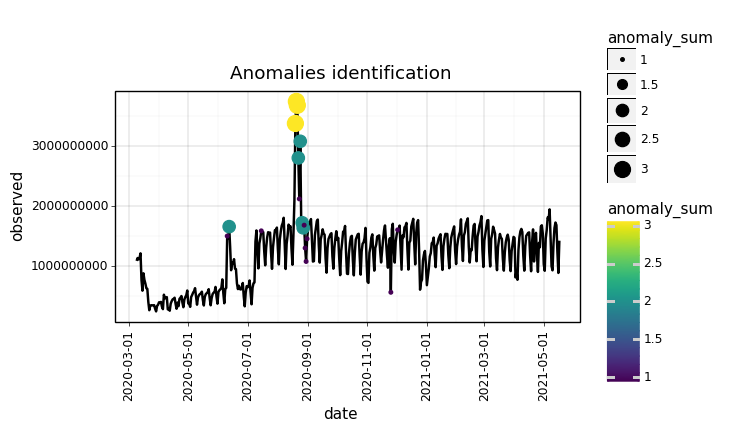

2021-05-19 00:32:09.381 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...


<ggplot: (8773689606601)>


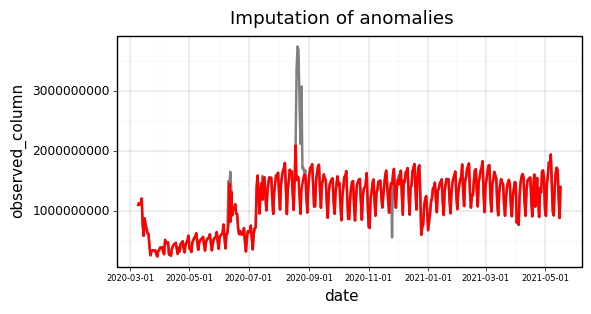

2021-05-19 00:32:09.760 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:32:09.761 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:32:09.761 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:32:09.763 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:32:09.769 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:32:09.770 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 12.0


<ggplot: (8773684067737)>


2021-05-19 00:32:10.328 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:32:10.329 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:32:10.330 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:32:10.567 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at 2020-07-08 00:00:00
2021-05-19 00:32:10.571 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:32:10.571 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: -690853167.0678744
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

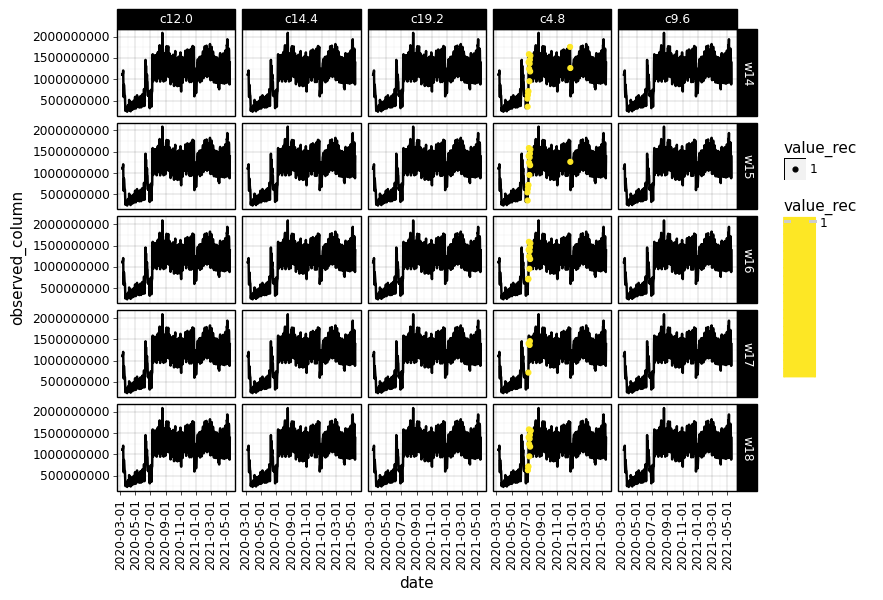

<ggplot: (8773685812465)>


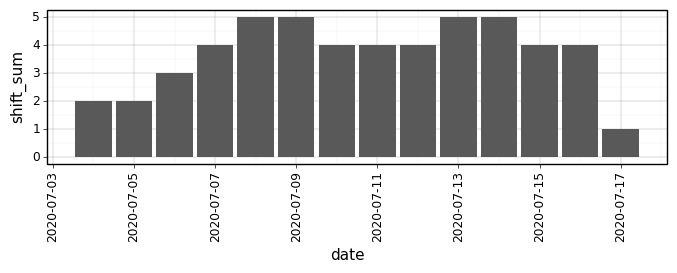

<ggplot: (8773683195153)>


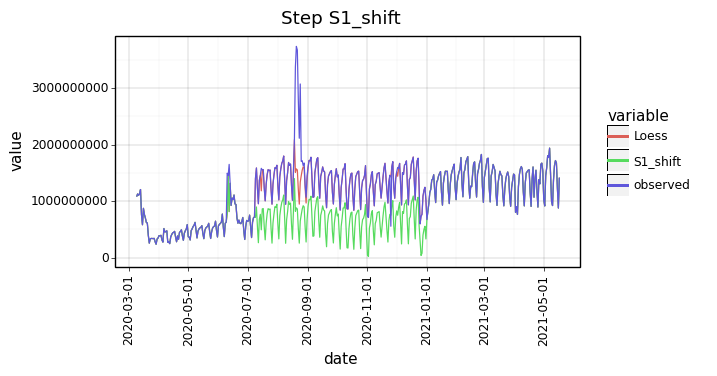

2021-05-19 00:32:26.092 | DEBUG    | src.runners.clean:_run_step:835 - ... step done ...
2021-05-19 00:32:26.097 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:32:26.098 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:32:26.099 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:32:26.100 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:32:26.106 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-19 00:32:26.106 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be s

<ggplot: (8773690250693)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 431 rows containing missing values.


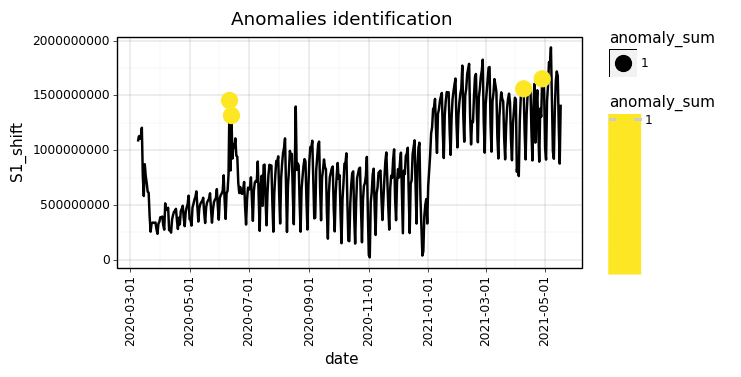

2021-05-19 00:32:26.606 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...


<ggplot: (8773690060521)>


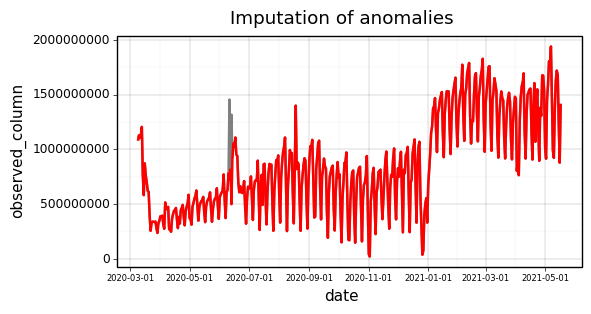

2021-05-19 00:32:26.993 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:32:26.994 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:32:26.994 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:32:26.996 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:32:27.001 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:32:27.002 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 12.0


<ggplot: (8773698150053)>


2021-05-19 00:32:27.550 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:32:27.551 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:32:27.552 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:32:27.783 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:32:27.786 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:32:27.787 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

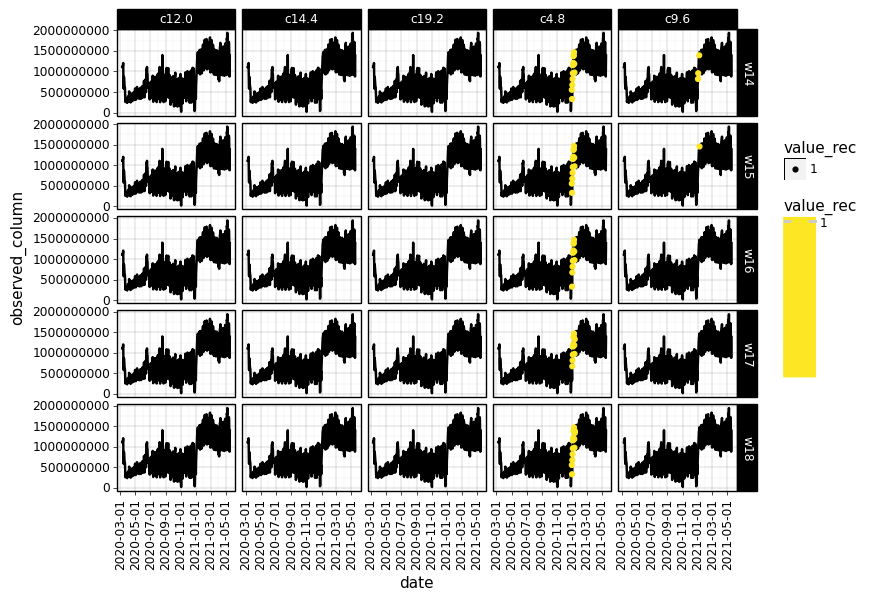

<ggplot: (8773682464133)>


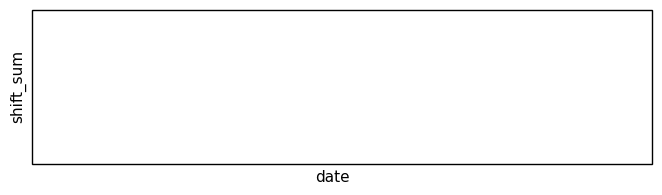

<ggplot: (8773680037229)>


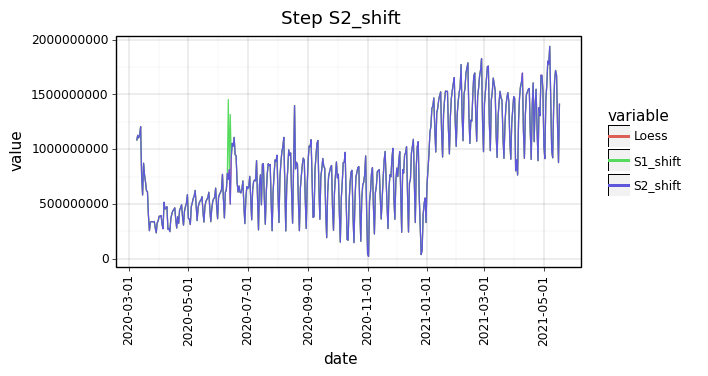

2021-05-19 00:32:42.917 | DEBUG    | src.runners.clean:_run_step:835 - ... step done ...
2021-05-19 00:32:43.096 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...


<ggplot: (8773696384117)>


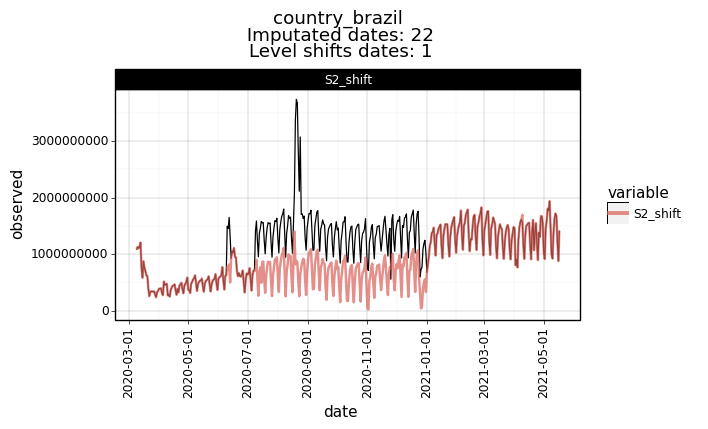

<ggplot: (8773679470997)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_brazil.pdf
2021-05-19 00:32:46.447 | INFO     | src.runners.clean:_run_single:906 - ... country_brazil done ...



In [39]:
daily, weekly = _run_single(region_slug='country_brazil', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            c_metric = 'max', 
                            f_metric = 4, 
                            print_report = True, 
                            print_plot = True)

In [ ]:
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

In [ ]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line(size= 1, alpha = .7)
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red', size= 1, alpha = .7)
 + p9.theme(figure_size=(6, 3),
            axis_text_x=p9.element_text(size = 7)) )
gg 

In [ ]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line(size= 1, alpha = .7)
 + p9.theme(figure_size=(6, 3),
            axis_text_x=p9.element_text(size = 7)) )
gg 

In [ ]:
weekly.head(3)
gg = (p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
gg

In [ ]:
print(daily.date.min())
print(daily.date.max())
print(weekly.week.max())

#### Run by batch

In [9]:
from src.runners.clean import _run_batch 

In [44]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona", 
          c_metric = 'max')

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
2021-05-19 00:39:14.259 | INFO     | src.runners.clean:_run_batch:924 - TO DO regions  81
2021-05-19 00:39:14.260 | INFO     | src.runners.clean:_run_single:852 - ... here we go aguascalientes...

2021-05-19 00:39:14.261 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        
2021-05-19 00:39:16.844 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.0273899198125596
2021-05-19 00:39:16.863 | DEBUG    | src.runners.clean:_c_param:364 - C max: 100
2021-05-19 00:39:16.866 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-0

2021-05-19 00:39:19.003 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_aguascalientes.pdf
2021-05-19 00:39:20.453 | INFO     | src.runners.clean:_run_single:906 - ... aguascalientes done ...

2021-05-19 00:39:20.455 | INFO     | src.runners.clean:_run_single:852 - ... here we go arequipa...

2021-05-19 00:39:20.455 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('arequipa')
        
2021-05-19 00:39:21.941 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.3707797834677795
2021-05-19 00:

2021-05-19 00:39:23.058 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:39:23.100 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:39:23.101 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:39:23.101 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:39:23.103 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:39:23.108 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:39:23.109 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:39:23.663 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:39:23.663 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:39:23.664 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:39:28.964 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.76668667025904
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:39:29.052 | DEBUG    | src.runners.clean:_find_anomalies:221 - Number of anomalies found: 33

2021-05-19 00:39:29.053 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-14 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11

2021-05-19 00:39:34.086 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:39:34.088 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:39:34.321 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:39:34.325 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:39:34.327 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19

2021-05-19 00:39:39.708 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:39:39.750 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:39:39.750 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:39:39.751 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:39:39.753 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:39:39.758 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:39:39.759 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:39:40.317 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:39:40.317 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:39:40.318 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:39:46.125 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-28 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2021-01-30 00:00:00'), Timestamp('2021-03-22 00:00:00'), Timestamp('2021-03-29 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-04-03 00:00:00'), Timestamp('2021-04-08 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-10 00:00:00'), Timestamp('2021-04-11 00:00:00'), Timestamp('2021-04-12 00:00:00'), Timestamp('2021-04-16 00:00:00'), Timestamp('2021-04-19 00:00:00'), Timestamp('2021-04-24 00:00:00'), Timestamp('2021-04-25 00:00:00'), Time

2021-05-19 00:39:52.546 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-10-11 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-18 00:00:00'), Timestamp('2020-10-19 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2020-11-03 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-11 00:00:00'), Timestamp('2021-02-12 00:00:00'), Time

2021-05-19 00:39:59.629 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:39:59.630 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-19 00:39:59.636 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6872269818077374
2021-05-19 00:39:59.637 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.6872269818077374
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:39:59.730 | DEBUG    | src.runners.clean:_find_an

2021-05-19 00:40:01.810 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_bucaramanga.pdf
2021-05-19 00:40:03.362 | INFO     | src.runners.clean:_run_single:906 - ... bucaramanga done ...

2021-05-19 00:40:03.363 | INFO     | src.runners.clean:_run_single:852 - ... here we go buenosaires...

2021-05-19 00:40:03.364 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('buenosaires')
        
2021-05-19 00:40:06.551 | DEBUG    | src.runners.clean:_c_param:364 - C max: 0.9098498045084976
2021-05-19 00:

2021-05-19 00:40:08.514 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:40:08.515 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:08.516 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:40:08.749 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:40:08.753 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:40:08.753 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

2021-05-19 00:40:15.079 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:40:15.121 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:40:15.122 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:40:15.123 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:40:15.126 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:40:15.131 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:40:15.131 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:40:15.686 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:40:15.687 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:15.688 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:40:21.404 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-20 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-13 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-10-11 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-14 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-14 00:00:00'), Timestamp('2021-02-26 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-21 00:00:00'), Timestamp('2021-04-28 00:00:00'), Time

2021-05-19 00:40:27.517 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:40:27.517 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:40:27.518 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:40:27.518 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:40:27.524 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5510305787633392
2021-05-19 00:40:27.524 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5510305787633392
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

2021-05-19 00:40:32.507 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:32.507 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:40:32.853 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:40:32.860 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:40:32.863 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19

2021-05-19 00:40:37.265 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:40:37.270 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:40:37.271 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 25.618812740906513
2021-05-19 00:40:37.825 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:40:37.826 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:37.827 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:40:38.063 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:40:38.066 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:40:38.067 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

2021-05-19 00:40:44.153 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:40:44.196 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:40:44.196 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:40:44.197 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:40:44.199 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:40:44.205 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:40:44.205 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 39.15860976235769
2021-05-19 00:40:44.759 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:40:44.760 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:44.762 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start Non

2021-05-19 00:40:51.446 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:40:51.489 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:40:51.489 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:40:51.490 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:40:51.492 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:40:51.498 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:40:51.498 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 60.0
2021-05-19 00:40:52.056 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:40:52.057 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:52.058 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021

2021-05-19 00:40:58.775 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:40:58.817 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:40:58.818 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:40:58.818 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:40:58.820 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:40:58.826 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:40:58.826 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 82.85489047705676
2021-05-19 00:40:59.382 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:40:59.382 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:40:59.383 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start Non

2021-05-19 00:41:03.749 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:41:03.791 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:41:03.792 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:41:03.792 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:41:03.794 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:41:03.800 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:41:03.800 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 33.831489848875115
2021-05-19 00:41:04.356 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:41:04.357 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:41:04.359 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start No

2021-05-19 00:41:08.665 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:41:08.708 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:41:08.709 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:41:08.710 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:41:08.712 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:41:08.717 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:41:08.718 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 32.135170416955795
2021-05-19 00:41:09.279 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:41:09.280 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:41:09.282 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start No

2021-05-19 00:41:14.587 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:41:14.630 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:41:14.631 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:41:14.632 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:41:14.634 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:41:14.639 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:41:14.640 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 26.702904631432766
2021-05-19 00:41:15.197 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:41:15.198 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:41:15.199 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start No

2021-05-19 00:41:19.716 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-03-02 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-21 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-04-03 00:00:00'), Timestamp('2021-04-04 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-10 00:00:00'), Timestamp('2021-04-11 00:00:00'), Time

2021-05-19 00:41:26.594 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.983635178740892
2021-05-19 00:41:26.613 | DEBUG    | src.runners.clean:_c_param:364 - C max: 39.67270357481784
2021-05-19 00:41:26.616 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:41:26.617 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:41:26.619 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:41:26.619 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-19 00:41:26.624 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.983635178740892
2021-05-19 00:41:26.625 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.983635178740892
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

2021-05-19 00:41:30.066 | INFO     | src.runners.clean:_run_single:906 - ... country_el_salvador done ...

2021-05-19 00:41:30.068 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_guatemala...

2021-05-19 00:41:30.069 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_guatemala')
        
2021-05-19 00:41:31.418 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.3497639329038027
2021-05-19 00:41:31.439 | DEBUG    | src.runners.clean:_c_param:364 - C max: 26.995278658076053
2021-05-19 00:41:31.443 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:41:31.443 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:41:31.444 | DEBUG    | src.runners.cle

2021-05-19 00:41:33.609 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_guatemala.pdf
2021-05-19 00:41:35.048 | INFO     | src.runners.clean:_run_single:906 - ... country_guatemala done ...

2021-05-19 00:41:35.050 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_honduras...

2021-05-19 00:41:35.050 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_honduras')
        
2021-05-19 00:41:36.488 | DEBUG    | src.runners.clean:_c_param:364 - C max: 3.0
2021-05

2021-05-19 00:41:39.938 | INFO     | src.runners.clean:_run_single:906 - ... country_honduras done ...

2021-05-19 00:41:39.940 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_jamaica...

2021-05-19 00:41:39.941 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_jamaica')
        
2021-05-19 00:41:42.282 | DEBUG    | src.runners.clean:_c_param:364 - C max: 2.1973952336567217
2021-05-19 00:41:42.302 | DEBUG    | src.runners.clean:_c_param:364 - C max: 43.94790467313443
2021-05-19 00:41:42.305 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:41:42.306 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:41:42.306 | DEBUG    | src.runners.clean:_find

2021-05-19 00:41:46.109 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_mexico...

2021-05-19 00:41:46.109 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_mexico')
        
2021-05-19 00:41:49.776 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.0694676769115674
2021-05-19 00:41:49.794 | DEBUG    | src.runners.clean:_c_param:364 - C max: 21.389353538231347
2021-05-19 00:41:49.798 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:41:49.798 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:41:49.799 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:41:49.800 | DEBUG    | src.runners.clean:_valida

2021-05-19 00:41:51.964 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_mexico.pdf
2021-05-19 00:41:53.322 | INFO     | src.runners.clean:_run_single:906 - ... country_mexico done ...

2021-05-19 00:41:53.324 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_nicaragua...

2021-05-19 00:41:53.325 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_nicaragua')
        
2021-05-19 00:41:55.729 | DEBUG    | src.runners.clean:_c_param:364 - C max: 3.2622002082774

2021-05-19 00:41:59.256 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_panama...

2021-05-19 00:41:59.258 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_panama')
        
2021-05-19 00:42:00.654 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.6702005697603717
2021-05-19 00:42:00.673 | DEBUG    | src.runners.clean:_c_param:364 - C max: 33.404011395207434
2021-05-19 00:42:00.677 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:42:00.677 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:42:00.678 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:42:00.679 | DEBUG    | src.runners.clean:_valida

2021-05-19 00:42:02.872 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_country_panama.pdf
2021-05-19 00:42:04.342 | INFO     | src.runners.clean:_run_single:906 - ... country_panama done ...

2021-05-19 00:42:04.344 | INFO     | src.runners.clean:_run_single:852 - ... here we go country_paraguay...

2021-05-19 00:42:04.344 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_paraguay')
        
2021-05-19 00:42:05.713 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.667576148278834

2021-05-19 00:42:06.883 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:42:06.884 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 33.35152296557669
2021-05-19 00:42:07.437 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:42:07.438 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:42:07.439 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:42:07.675 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:42:07.678 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:42:07.679 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

2021-05-19 00:42:12.732 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-16 00:00:00'), Timestamp('2020-09-06 00:00:00'), Timestamp('2020-09-13 00:00:00'), Timestamp('2020-11-21 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-13 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2021-04-04 00:00:00'), Timestamp('2021-04-11 00:00:00'), Timestamp('2021-04-17 00:00:00'), Timestamp('2021-04-18 00:00:00'), Timestamp('2021-04-25 00:00:00'), Timestamp('2021-05-02 00:00:00'), Timestamp('2021-05-09 00:00:00'), Timestamp('2021-05-16 00:00:00')]
2021-05-19 00:42:12.736 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:42:12.776 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-0

2021-05-19 00:42:19.628 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:42:19.629 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:42:19.629 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:42:19.634 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:42:19.635 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

2021-05-19 00:42:25.070 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:42:25.072 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:42:25.072 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:42:25.074 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:42:25.079 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-19 00:42:25.080 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

2021-05-19 00:42:32.097 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:42:32.098 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:42:32.098 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:42:32.099 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:42:32.104 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.077252636557924
2021-05-19 00:42:32.104 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 2.077252636557924
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

2021-05-19 00:42:40.153 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:42:40.154 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:42:40.154 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:42:40.155 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:42:40.160 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-19 00:42:40.161 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 3
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:42:45.405 | DEBUG    | src.runners.clean:_run_step:835 - ... step done ...
2021-05-19 00:42:45.407 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:42:45.408 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:42:45.410 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:42:45.411 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shif

2021-05-19 00:42:50.633 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:42:50.675 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:42:50.676 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:42:50.677 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:42:50.679 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:42:50.684 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:42:50.684 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:42:51.237 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:42:51.238 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:42:51.238 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:42:56.684 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-11 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-18 00:00:00'), Timestamp('2020-10-19 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-15 00:00:00'), Timestamp('2020-11-22 00:00:00'), Timestamp('2020-11-25 00:00:00'), Time

2021-05-19 00:43:02.323 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.341901667057806
2021-05-19 00:43:02.347 | DEBUG    | src.runners.clean:_c_param:364 - C max: 100
2021-05-19 00:43:02.351 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:43:02.352 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:43:02.352 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:43:02.354 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-19 00:43:02.359 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:43:02.359 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

2021-05-19 00:43:06.000 | INFO     | src.runners.clean:_run_single:906 - ... guadalajara done ...

2021-05-19 00:43:06.002 | INFO     | src.runners.clean:_run_single:852 - ... here we go guatemala...

2021-05-19 00:43:06.004 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guatemala')
        
2021-05-19 00:43:07.565 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.6609323947431904
2021-05-19 00:43:07.586 | DEBUG    | src.runners.clean:_c_param:364 - C max: 100
2021-05-19 00:43:07.589 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:43:07.590 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:43:07.590 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding o

2021-05-19 00:43:09.735 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_guatemala.pdf
2021-05-19 00:43:11.006 | INFO     | src.runners.clean:_run_single:906 - ... guatemala done ...

2021-05-19 00:43:11.008 | INFO     | src.runners.clean:_run_single:852 - ... here we go guayaquil...

2021-05-19 00:43:11.011 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guayaquil')
        
2021-05-19 00:43:12.684 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.0869959841260328
2021-05-19 00:43:12.70

2021-05-19 00:43:13.804 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:43:13.845 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:43:13.845 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:43:13.846 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:43:13.848 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:43:13.853 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:43:13.854 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:43:14.407 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:43:14.408 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:43:14.408 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:43:18.821 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:43:18.863 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:43:18.863 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:43:18.864 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:43:18.866 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:43:18.871 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:43:18.872 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:43:19.424 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:43:19.425 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:43:19.426 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:43:23.895 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:43:23.936 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:43:23.937 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:43:23.937 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:43:23.939 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:43:23.944 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:43:23.945 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:43:24.498 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:43:24.499 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:43:24.500 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:43:30.013 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:43:30.057 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:43:30.058 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:43:30.058 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:43:30.060 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:43:30.065 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:43:30.066 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:43:30.621 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:43:30.622 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:43:30.623 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:43:36.895 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:43:36.896 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:43:36.897 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:43:36.898 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:43:36.903 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:43:36.903 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

2021-05-19 00:43:41.366 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:43:41.408 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:43:41.408 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:43:41.409 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:43:41.411 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:43:41.416 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:43:41.417 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:43:41.972 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:43:41.973 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:43:41.973 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:43:48.503 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-15 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-14 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-21 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-02 00:00:00'), Time

2021-05-19 00:43:54.390 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:43:54.390 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:43:54.391 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:43:54.392 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-19 00:43:54.397 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:43:54.399 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

2021-05-19 00:43:56.082 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:43:56.083 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:43:56.317 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:43:56.320 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:43:56.321 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19

2021-05-19 00:44:00.473 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:44:00.513 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:44:00.514 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:44:00.515 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:44:00.518 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:44:00.522 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:44:00.523 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:44:01.076 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:44:01.077 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:44:01.080 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:44:05.529 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:44:05.571 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:44:05.571 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:44:05.572 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:44:05.574 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:44:05.578 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:44:05.579 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:44:06.129 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:44:06.129 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:44:06.130 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:44:12.345 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-04-11 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-08-01 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2020-11-21 00:00:00'), Timestamp('2020-11-22 00:00:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2021-02-08 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-21 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2021-04-04 00:00:00'), Timestamp('2021-04-11 00:00:00'), Timestamp('2021-04-18 00:00:00'), Timestamp('2021-05-04 00:00:00'), Timestamp('2021-05-06 00:00:00'), Timestamp('2021-05-07 00:00:00'), Timestamp('2021-05-16 00:00:00')]
2021-05-19 00:44:12.347 | DEBUG    | src.runners.clean:_impute_anomalies

2021-05-19 00:44:18.493 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:44:18.498 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:44:18.499 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:44:18.588 | DEBUG    | src.runners.clean:_find_anomalies:221 - Number of anomalies found: 14

2021-05-19 00:44:18.588 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp(

2021-05-19 00:44:26.631 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:44:26.631 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:44:26.632 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:44:26.637 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:44:26.637 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

2021-05-19 00:44:31.709 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:44:31.709 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:44:32.261 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:44:32.262 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:44:32.262 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:44:32.498 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:44:32.502 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:44:32.502 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

2021-05-19 00:44:36.634 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:44:36.678 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:44:36.679 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:44:36.680 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:44:36.682 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:44:36.687 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:44:36.687 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:44:37.428 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:44:37.429 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:44:37.432 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:44:42.768 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-22 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2021-03-29 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-02 00:00:00'), Time

2021-05-19 00:44:48.020 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:44:48.021 | INFO     | src.runners.clean:_run_step:783 - Target variable: observed 

2021-05-19 00:44:48.021 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:44:48.022 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-19 00:44:48.028 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:44:48.028 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

2021-05-19 00:44:50.170 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_porto_alergre.pdf
2021-05-19 00:44:51.496 | INFO     | src.runners.clean:_run_single:906 - ... porto_alergre done ...

2021-05-19 00:44:51.498 | INFO     | src.runners.clean:_run_single:852 - ... here we go pueble...

2021-05-19 00:44:51.501 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('pueble')
        
2021-05-19 00:44:54.227 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.145334843552123
2021-05-19 00:44:54.2

../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:44:56.221 | DEBUG    | src.runners.clean:_run_step:835 - ... step done ...
2021-05-19 00:44:56.397 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_pueble.pdf
2021-05-19 00:44:57.930 | INFO     | src.runners.clea

2021-05-19 00:45:01.444 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:45:01.447 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:45:01.448 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:45:01.485 | DEBUG    | src.runners.clean:_run_step:835 - ... step done ...
2021-05-19 00:45:01.663 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/e

2021-05-19 00:45:06.915 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:45:06.955 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:45:06.956 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:45:06.957 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:45:06.958 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:45:06.963 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:45:06.964 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:45:07.559 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:45:07.562 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:45:07.563 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:45:13.188 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-04-10 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-10-26 00:00:00'), Timestamp('2020-11-08 00:00:00'), Timestamp('2020-11-15 00:00:00'), Timestamp('2020-11-22 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-14 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-17 00:00:00'), Timestamp('2021-03-01 00:00:00'), Timestamp('2021-03-06 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-19 00:00:00'), Timestamp('2021-03-23 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-18 00:00:00'), Time

2021-05-19 00:45:21.804 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:45:21.806 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:45:21.807 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:45:21.808 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:45:21.813 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:45:21.814 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

2021-05-19 00:45:26.482 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:45:26.487 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:45:26.488 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:45:27.046 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:45:27.047 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:45:27.048 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:45:27.282 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:45:27.285 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:45:27.286 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

2021-05-19 00:45:33.137 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:45:33.180 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:45:33.181 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:45:33.181 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:45:33.183 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:45:33.189 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:45:33.189 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:45:33.741 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:45:33.742 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:45:33.743 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:45:39.183 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:45:39.225 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:45:39.226 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:45:39.227 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:45:39.228 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:45:39.234 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:45:39.235 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:45:39.787 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:45:39.788 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:45:39.789 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:45:44.124 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-07-27 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-22 00:00:00'), Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-04-03 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-12 00:00:00'), Timestamp('2021-05-13 00:00:00')]
2021-05-19 00:45:44.126 | DEBUG    | src.runners.clean:_impute_anomalies

2021-05-19 00:45:49.319 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-14 00:00:00'), Timestamp('2020-08-16 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-06 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-11-06 00:00:00'), Timestamp('2020-11-22 00:00:00'), Timestamp('2020-11-29 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-24 00:00:00'), Time

2021-05-19 00:45:51.360 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sansalvador.pdf
2021-05-19 00:45:52.649 | INFO     | src.runners.clean:_run_single:906 - ... sansalvador done ...

2021-05-19 00:45:52.651 | INFO     | src.runners.clean:_run_single:852 - ... here we go santacruzdelasierra...

2021-05-19 00:45:52.652 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santacruzdelasierra')
        
2021-05-19 00:45:55.080 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.247482473011330

2021-05-19 00:45:56.232 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:45:56.233 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:45:56.234 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:45:56.239 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:45:56.242 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:45:56.790 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:45:56.790 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:45:56.791 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:45:57.026 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:45:57.029 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:45:57.030 | DEBUG   

2021-05-19 00:46:01.403 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:46:01.971 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:46:01.972 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:46:01.974 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:46:02.209 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:46:02.212 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:46:02.214 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set o

2021-05-19 00:46:06.569 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:46:06.611 | INFO     | src.runners.clean:_run_step:802 - Output variable S2_shift
2021-05-19 00:46:06.611 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:46:06.612 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:46:06.614 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:46:06.619 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:46:06.620 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:46:07.170 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:46:07.171 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:46:07.172 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:46:11.611 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:46:11.612 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:46:11.613 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:46:11.613 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:46:11.618 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:46:11.619 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

2021-05-19 00:46:16.975 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:46:17.018 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:46:17.019 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:46:17.019 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:46:17.021 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:46:17.027 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:46:17.027 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:46:17.577 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:46:17.578 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:46:17.579 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

2021-05-19 00:46:22.636 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-10-11 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2021-02-12 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-05-07 00:00:00'), Timestamp('2021-05-12 00:00:00')]
2021-05-19 00:46:22.639 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:46:22.680 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-0

2021-05-19 00:46:27.813 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-10-08 00:00:00'), Timestamp('2020-10-09 00:00:00'), Timestamp('2020-10-29 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-06 00:00:00'), Timestamp('2020-11-12 00:00:00'), Timestamp('2020-11-18 00:00:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-07 00:00:00'), Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-25 00:00:00'), Timestamp('2021-02-26 00:00:00')]
2021-05-19 00:46:27.815 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:46:27.858 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-0

2021-05-19 00:46:33.949 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-02-14 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-26 00:00:00'), Time

2021-05-19 00:46:40.729 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:46:40.730 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-19 00:46:40.735 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:46:40.738 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:46:40.829 | DEBUG    | src.runners.clean:_find_anomalies:221 - Number of anomal

2021-05-19 00:46:42.867 | DEBUG    | src.runners.clean:_write_missing:710 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_saopaulo.pdf
2021-05-19 00:46:44.249 | INFO     | src.runners.clean:_run_single:906 - ... saopaulo done ...

2021-05-19 00:46:44.251 | INFO     | src.runners.clean:_run_single:852 - ... here we go sorocaba...

2021-05-19 00:46:44.252 | DEBUG    | src.runners.clean:_reading_data:703 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sorocaba')
        
2021-05-19 00:46:46.703 | DEBUG    | src.runners.clean:_c_param:364 - C max: 1.3518559706673363
2021-05-19 00:46:46.721 | 

2021-05-19 00:46:47.861 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:46:47.861 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:46:48.411 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:46:48.412 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:46:48.413 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-05-19 00:46:48.647 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:46:48.650 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:46:48.651 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

2021-05-19 00:46:52.840 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-11-16 00:00:00'), Timestamp('2020-11-28 00:00:00'), Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-03 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-12 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-23 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-14 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-03-19 00:00:00'), Timestamp('2021-03-26 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-04-11 00:00:00'), Timestamp('2021-04-16 00:00:00'), Timestamp('2021-04-24 00:00:00'), Timestamp('2021-04-25 00:00:00'), Timestamp('2021-05-02 00:00:00'), Timestamp('2021-05-09 00:00:00'), Timestamp('2021-05-10 00:00:00'), Time

2021-05-19 00:46:58.701 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:46:58.702 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:46:58.790 | DEBUG    | src.runners.clean:_find_anomalies:221 - Number of anomalies found: 17

2021-05-19 00:46:58.791 | DEBUG    | src.runners.clean:_find_anomalies:222 - [Timestamp('2020-08-18 00:00:00'), Timestamp('2020-10-11 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('20

2021-05-19 00:47:05.835 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:47:05.836 | INFO     | src.runners.clean:_run_step:783 - Target variable: S1_shift 

2021-05-19 00:47:05.836 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-05-19 00:47:05.837 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-19 00:47:05.842 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-19 00:47:05.842 | DEBUG    | src.runners.clean:_anomalies_detector:159 - C_TRUNC 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

2021-05-19 00:47:10.851 | DEBUG    | src.runners.clean:_initial_shift_date:497 - Shift found at NaT
2021-05-19 00:47:10.854 | DEBUG    | src.runners.clean:_shift_ts:530 - 

2021-05-19 00:47:10.855 | DEBUG    | src.runners.clean:_shift_ts:531 - Center point: nan
../src/runners/clean.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-19 00:47:10.893 | DEBUG    | src.runners.clean:_run_step:835 - ... step done ...
2021-05-19 00:47:10.895 | DEBUG    | src.runners.clean:_run_step:782 - ... step start ...
2021-05-19 00:47:10.896 | INFO     | sr

2021-05-19 00:47:16.206 | DEBUG    | src.runners.clean:_impute_anomalies:304 - 
... imputing outliers ...
2021-05-19 00:47:16.248 | INFO     | src.runners.clean:_run_step:802 - Output variable S1_shift
2021-05-19 00:47:16.249 | DEBUG    | src.runners.clean:_shift_level:558 - 

2021-05-19 00:47:16.249 | DEBUG    | src.runners.clean:_shift_level:559 - ... shifting levels for Loess ...
2021-05-19 00:47:16.251 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-19 00:47:16.256 | DEBUG    | src.runners.clean:_run_shift_grid:414 - ... shift level running grid  ...

2021-05-19 00:47:16.257 | DEBUG    | src.runners.clean:_run_shift_grid:416 - C_LS 100
2021-05-19 00:47:16.808 | DEBUG    | src.runners.clean:_run_shift_grid:436 - Total combinations: 25

2021-05-19 00:47:16.809 | DEBUG    | src.runners.clean:_shift_sum:459 - LS 2020 Start 2020-03-31 - 2020-12-15
2021-05-19 00:47:16.809 | DEBUG    | src.runners.clean:_shift_sum:460 - LS 2021 Start None - None
2021-

## Comparison

In [18]:
import pandas as pd
from siuba import *

### Daily

#### Several experiments

In [49]:
df_list = list()
for k in range(5):
    file = ['ls1', 'ls4', 'ls20', 'ls100', 'lsmix'][k]
    print(file)
    metric = ['', '_ls_4X', '_ls_20X', '_ls_OFF', '_ls_MIX'][k]
    
    df = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max_{file}.csv")
    df = df[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':f'tci_cleaned{metric}', 
                           'tcp_clean':f'tcp_cleaned{metric}'}) 
    print(df.shape)
    df_list.append(df)
    
from functools import reduce
df_union = reduce(lambda x, y: pd.merge(x, y, on = ['date', 'region_slug', 'tci_observed', 'tcp_observed']), df_list)
print(df_union.shape)
print(df_union.date.max())
df_union.head(2)    

ls1
(35235, 6)
ls4
(35235, 6)
ls20
(35235, 6)
ls100
(35235, 6)
lsmix
(35235, 6)
(35235, 14)
2021-05-17


,date,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
0,2020-06-08,aguascalientes,1118441,-48.762352,1118441.0,-48.762352,1118441.0,-48.762352,1118441.0,-48.762352,1118441.0,-48.762352,1118441.0,-48.762352
1,2020-05-11,aguascalientes,767569,-64.836384,767569.0,-64.836384,767569.0,-64.836384,767569.0,-64.836384,767569.0,-64.836384,767569.0,-64.836384


#### Final result

In [ ]:
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
print(df_max.date.max())
df_max.head()

In [ ]:
df_max = df_max[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_cleaned', 
                       'tcp_clean':'tcp_cleaned'}) 

In [ ]:
df_union = df_max 
print(df_max.shape)

#### Export daily data to csv

In [50]:
df_union.describe()

,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
count,3.523500e+04,35235.000000,3.523500e+04,35235.000000,3.523500e+04,35235.000000,3.523500e+04,35235.000000,3.523500e+04,35235.000000,3.523500e+04,35235.000000
mean,4.014292e+07,-33.115915,3.324677e+07,-42.261018,3.383771e+07,-40.139148,3.801348e+07,-35.595615,3.894223e+07,-35.363857,3.801348e+07,-35.595615
std,1.533097e+08,49.786067,1.166209e+08,38.785630,1.171909e+08,39.414551,1.432977e+08,43.475575,1.460769e+08,43.754669,1.432977e+08,43.475575
min,1.392000e+03,-99.842676,6.878220e+02,-99.920695,1.392000e+03,-99.842676,1.392000e+03,-99.842676,1.392000e+03,-99.842676,1.392000e+03,-99.842676
25%,2.267847e+06,-67.345542,1.966840e+06,-69.062238,2.090787e+06,-67.924562,2.288842e+06,-66.498457,2.288842e+06,-66.498235,2.288842e+06,-66.498457
50%,7.310489e+06,-39.759435,6.354820e+06,-48.051126,6.654152e+06,-45.503413,7.293648e+06,-40.572375,7.293648e+06,-40.557201,7.293648e+06,-40.572375
75%,2.132935e+07,-10.784841,1.932243e+07,-23.169319,2.001249e+07,-19.966675,2.076981e+07,-14.253936,2.076981e+07,-14.005295,2.076981e+07,-14.253936
max,3.742041e+09,1036.781062,1.939426e+09,370.374870,1.939426e+09,341.732005,1.939426e+09,379.376297,1.939426e+09,379.376297,1.939426e+09,379.376297


In [51]:
df_union.to_csv("/home/soniame/private/daily_index_index.csv", index=False)

In [52]:
print(df_union.date.max())
df_union[df_union.region_slug == 'lima'].tail()

2021-05-17


,date,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
19135,2020-09-11,lima,66193336,-30.096766,6.463243e+07,-31.745153,66193336.0,-30.096766,66193336.0,-30.096766,66193336.0,-30.096766,66193336.0,-30.096766
19136,2020-03-27,lima,8645366,-90.870092,8.645366e+06,-90.870092,8645366.0,-90.870092,8645366.0,-90.870092,8645366.0,-90.870092,8645366.0,-90.870092
19137,2020-05-08,lima,11036430,-88.345018,1.103643e+07,-88.345018,11036430.0,-88.345018,11036430.0,-88.345018,11036430.0,-88.345018,11036430.0,-88.345018
19138,2020-08-14,lima,59727743,-36.924732,5.816684e+07,-38.573119,59727743.0,-36.924732,59727743.0,-36.924732,59727743.0,-36.924732,59727743.0,-36.924732
19139,2020-11-23,lima,63150143,-2.052441,6.158924e+07,-4.473445,63150143.0,-2.052441,63150143.0,-2.052441,63150143.0,-2.052441,63150143.0,-2.052441


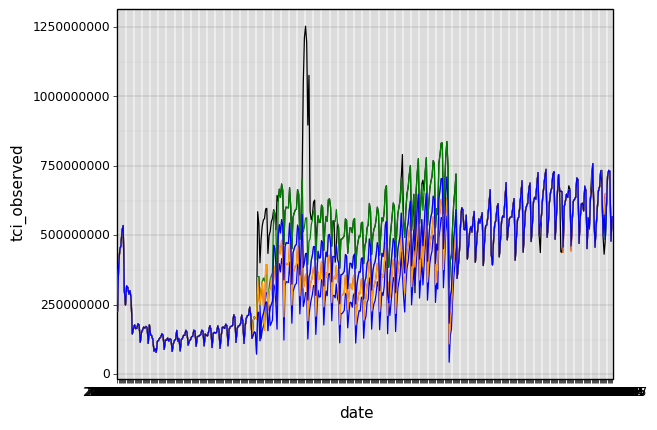

<ggplot: (8773712527465)>

In [54]:
import plotnine as p9
gg = (p9.ggplot(df_union[df_union.region_slug == 'country_mexico'],
                    p9.aes(x = 'date', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes(y = 'tci_cleaned'), color = 'gray')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_20X'), color = 'red')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_4X'), color = 'blue')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_OFF'), color = 'green')
 + p9.geom_line(p9.aes(y = 'tci_cleaned_ls_MIX'), color = 'orange')
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
gg

### Weekly

#### Several experiments

In [56]:
df_list = list()
for k in range(5):
    file = ['ls1', 'ls4', 'ls20', 'ls100', 'lsmix'][k]
    print(file)
    metric = ['', '_ls_4X', '_ls_20X', '_ls_OFF', '_ls_MIX'][k]
    df = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max_{file}.csv")
    df = df[['week', 'days_num', 'date_min', 'region_slug', 
             'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
        .rename(columns = {'tci_clean':f'tci_cleaned{metric}', 
                           'tcp_clean':f'tcp_cleaned{metric}'}) 
    print(df.shape)
    df_list.append(df)
    
from functools import reduce
df_union = reduce(lambda x, y: pd.merge(x, y, on = ['week', 'days_num', 'region_slug', 'date_min', 'tci_observed', 'tcp_observed']), df_list)
print(df_union.shape)
df_union.head(2)    

ls1
(5103, 8)
ls4
(5103, 8)
ls20
(5103, 8)
ls100
(5103, 8)
lsmix
(5103, 8)
(5103, 16)


,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464


#### Final result

In [ ]:
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max.csv")

df_max = df_max[df_max.days_num == 7][['week', 'days_num', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_cleaned', 
                       'tcp_clean':'tcp_cleaned'}) 

In [ ]:
print(df_max.shape)
df_union = df_max 

#### Export daily data to csv

In [57]:
df_union.describe()


,week,days_num,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
count,5103.000000,5103.000000,5.103000e+03,5103.000000,5.103000e+03,5103.000000,5.103000e+03,5103.000000,5.103000e+03,5103.000000,5.103000e+03,5103.000000,5.103000e+03,5103.000000
mean,32.000000,6.904762,2.771773e+08,-34.697730,2.295610e+08,-42.833584,2.336414e+08,-40.960205,2.624741e+08,-37.030968,2.688868e+08,-36.812526,2.624741e+08,-37.030968
std,18.186024,0.749979,1.040925e+09,42.913984,7.877037e+08,34.938990,7.912912e+08,35.396164,9.774349e+08,38.878590,9.970092e+08,39.150750,9.774349e+08,38.878590
min,1.000000,1.000000,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365
25%,16.000000,7.000000,1.694279e+07,-64.559622,1.504517e+07,-66.695424,1.587731e+07,-65.769506,1.687138e+07,-64.826716,1.687138e+07,-64.826716,1.687138e+07,-64.826716
50%,32.000000,7.000000,5.356461e+07,-37.493520,4.785263e+07,-47.491736,4.967100e+07,-44.818287,5.264957e+07,-38.806725,5.264957e+07,-38.806725,5.264957e+07,-38.806725
75%,48.000000,7.000000,1.478776e+08,-14.151371,1.325119e+08,-24.902541,1.348958e+08,-21.427016,1.424326e+08,-16.176905,1.424326e+08,-15.959368,1.424326e+08,-16.176905
max,63.000000,7.000000,1.931785e+10,486.853576,1.101594e+10,262.169619,1.101594e+10,262.209076,1.101594e+10,261.746328,1.101594e+10,261.746328,1.101594e+10,261.746328


In [58]:
print(df_union.week.max())
print(df_union.date_min.max())
df_union.head()

63
2021-05-17


,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464
2,3,7,2020-03-23,aguascalientes,5471700,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925
3,4,7,2020-03-30,aguascalientes,4701122,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593
4,5,7,2020-04-06,aguascalientes,3838557,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443


In [59]:
df_union.to_csv("/home/soniame/private/weekly_weekly_index.csv", index=False)

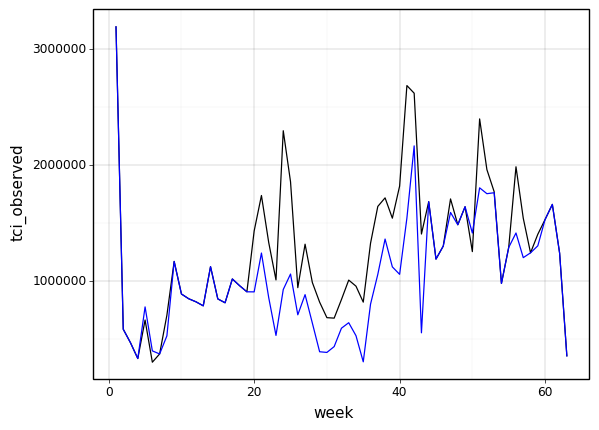

<ggplot: (8773680056653)>

In [60]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'kingston'],
                    p9.aes(x = 'week', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
gg

In [61]:
df_union.head()

,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464
2,3,7,2020-03-23,aguascalientes,5471700,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925
3,4,7,2020-03-30,aguascalientes,4701122,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593
4,5,7,2020-04-06,aguascalientes,3838557,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443


In [62]:
df.region_slug.unique()[:5]

array(['aguascalientes', 'arequipa', 'barranquilla', 'belem',
       'belohorizonte'], dtype=object)

#### Weekly in long format

In [63]:
df_weekly = pd.read_csv("/home/soniame/private/weekly_weekly_index.csv")
df_weekly.head(2)

,week,days_num,date_min,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned,tci_cleaned_ls_4X,tcp_cleaned_ls_4X,tci_cleaned_ls_20X,tcp_cleaned_ls_20X,tci_cleaned_ls_OFF,tcp_cleaned_ls_OFF,tci_cleaned_ls_MIX,tcp_cleaned_ls_MIX
0,1,7,2020-03-09,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,2020-03-16,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464


In [69]:
df_weekly_long = (df_weekly 
 >> select('week', 'days_num', 'date_min', 'region_slug', 
           'tci_observed',  'tci_cleaned', 
           'tci_cleaned_ls_4X', 'tci_cleaned_ls_20X', 
           'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX',
           'tcp_observed', 'tcp_cleaned', 
           'tcp_cleaned_ls_4X', 'tcp_cleaned_ls_20X', 
           'tcp_cleaned_ls_OFF', 'tcp_cleaned_ls_MIX')
 >> gather('measure', 'value', _["tci_observed":"tcp_cleaned_ls_MIX"])
 >> mutate(type = 'TCP')
)
tci_exist = df_weekly_long['measure'].isin(['tci_observed',  'tci_cleaned', 
           'tci_cleaned_ls_4X', 'tci_cleaned_ls_20X', 
           'tci_cleaned_ls_OFF', 'tci_cleaned_ls_MIX'])
df_weekly_long['type'][tci_exist] = 'TCI'

print(df_weekly_long.type.unique())
print(df_weekly_long.measure.unique())
head(df_weekly_long)

['TCI' 'TCP']
['tci_observed' 'tci_cleaned' 'tci_cleaned_ls_4X' 'tci_cleaned_ls_20X'
 'tci_cleaned_ls_OFF' 'tci_cleaned_ls_MIX' 'tcp_observed' 'tcp_cleaned'
 'tcp_cleaned_ls_4X' 'tcp_cleaned_ls_20X' 'tcp_cleaned_ls_OFF'
 'tcp_cleaned_ls_MIX']


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,week,days_num,date_min,region_slug,measure,value,type
0,1,7,2020-03-09,aguascalientes,tci_observed,18414201.0,TCI
1,2,7,2020-03-16,aguascalientes,tci_observed,9578544.0,TCI
2,3,7,2020-03-23,aguascalientes,tci_observed,5471700.0,TCI
3,4,7,2020-03-30,aguascalientes,tci_observed,4701122.0,TCI
4,5,7,2020-04-06,aguascalientes,tci_observed,3838557.0,TCI


In [70]:
df_weekly_long.to_csv("/home/soniame/private/weekly_weekly_index_long.csv")

#### Step run

In [ ]:
df_cty = _load_data()

In [ ]:
df_run_1 = _run_step(df_run = df_cty[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
df_run_1.head()

In [ ]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [ ]:
df.columns #sort_values('week_number')

In [ ]:
import pandas as pd
metadata = pd.read_csv("http://tiny.cc/idb-traffic-metadata")

In [ ]:
print(len(metadata.region_slug))
print(metadata.region_slug.unique())

metadata.head()

In [ ]:
metadata[metadata.region_slug == 'mexicocity'].region_shapefile_wkt.to_list()